# Analysis of Past Rewards
- Voting Strategy Performance

In [9]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

from voter.config import CONFIG
import steevebase.io as io

DB_ADDRESS = CONFIG['DATABASE']['ADDRESS']
db = io.mongo_factory(DB_ADDRESS)
monitor_col = db.get_collection("monitor")

%matplotlib notebook

CURATOR = 'hr1'
SHAREHOLDERS = ['hr1', 'mor', 'void']
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'

def is_withdraw(ir):
    return 'type' in ir and ir['type'] == 'fill_vesting_withdraw' and ir['from_account'] == CURATOR

def is_powerup(ir):
    return 'type' in ir and ir['type'] == 'transfer_to_vesting'

def is_claim_rewards(ir):
    return 'type' in ir and ir['type'] == 'claim_reward_balance'

def parse_vests(str_vests):
    str_split = str_vests.split(" ")
    assert str_split[1] == 'VESTS', str_split[1]
    return float(str_split[0])

def parse_steem(str_steem):
    str_split = str_steem.split(" ")
    assert str_split[1] == 'STEEM', str_split[1]
    return float(str_split[0])

def get_steem_vest_ratio(ir):
    return parse_steem(ir['deposited']) / parse_vests(ir['withdrawn'])

def get_steem_vest_ratio_at_approx(at_date):
    x0 = datetime.strptime('2017-07-10 22:46:33', TIME_FORMAT)
    y0_steem = 14757.171
    y0_vests = 30514058.906356
    
    x1 = datetime.strptime('2017-07-24 17:18:12', TIME_FORMAT)
    y1_steem = 15079.780
    y1_vests = 31158222.349691

#     x1 = datetime.strptime('2017-10-23 16:04:09', '%Y-%m-%d %H:%M:%S')
#     y1_steem = 15711.413
#     y1_vests = 32308995.197406
    
    ratio_0 = y0_steem / y0_vests
    ratio_1 = y1_steem / y1_vests
    
    d_x = (x1 - x0).total_seconds()
    d_y = ratio_1 - ratio_0
    
    k = d_y / d_x
    
    if not isinstance(at_date, datetime):
        at_date = datetime.strptime(at_date, TIME_FORMAT)
    
    res_ratio = ratio_0 + k * (at_date - x0).total_seconds()
    
    return res_ratio

def get_steem_vest_ratio_at(at_date, sp_vests):
    nonna_sp_vests = sp_vests.dropna()
    
    t0 = nonna_sp_vests['timestamp'].iloc[-2]
    t1 = nonna_sp_vests['timestamp'].iloc[-1]
    
    y0 = nonna_sp_vests['steem_vest_ratio'].iloc[-2]
    y1 = nonna_sp_vests['steem_vest_ratio'].iloc[-1]
    
    d_t = (t1 - t0).total_seconds()
    d_y = y1 - y0
    
#     if d_t == 0:
#         print(nonna_sp_vests.iloc[-2])
#         print(nonna_sp_vests.iloc[-1])
#         if d_y == 0:
#             k = y1
#         else:
#             raise ValueError('d_t == 0 and d_y != 0 !!!')
#     else:    
    k = d_y / d_t

#     print('d_t', d_t)
#     print('t0, t1', t0, t1)
#     print(nonna_sp_vests)
    
    if not isinstance(at_date, datetime):
        at_date = datetime.strptime(at_date, TIME_FORMAT)
    
    res_ratio = y1 + k * (at_date - t1).total_seconds()
    
    return res_ratio

def get_most_current_steem_vest_ratio(timestamp, sp_vests):
    if sp_vests.shape[0] > 1:
        return get_steem_vest_ratio_at(timestamp, sp_vests)
    else:
        print('\tget_steem_vest_ratio_at_approx')
        return get_steem_vest_ratio_at_approx(timestamp)

def split_rewards(sp_vests, ir):
    reward_vests = parse_vests(ir['reward_vests'])
    
    curr_sp_vests = sp_vests.iloc[-1]
    
    total_shares = curr_sp_vests[SHAREHOLDERS].sum()
    mor_shares = curr_sp_vests['mor'] / total_shares
    void_shares = curr_sp_vests['void'] / total_shares
    
    rewards = {}
    rewards['mor'] = multiplier['mor'] * mor_shares * reward_vests
    rewards['void'] = multiplier['void'] * void_shares * reward_vests
    rewards['hr1'] = reward_vests - sum([x for x in rewards.values()])
    rewards['timestamp'] = ir['timestamp']
    
    return rewards

def update_all_sp(sp_vests, rewards, steem_vest_ratio, timestamp):    
    curr_sp_vests = sp_vests.iloc[-1]
    next_sp_vests = {name: curr_sp_vests[name] + rewards[name] for name in SHAREHOLDERS}
    next_sp_vests['steem_vest_ratio'] = steem_vest_ratio
    next_sp_vests['timestamp'] = timestamp
    return sp_vests.append([next_sp_vests])


def update_hr1(sp_vests, amount, steem_vest_ratio, timestamp):
#     if pd.np.isnan(amount):
#         print('ted')
#         print(amount, steem_vest_ratio, timestamp)
#         print(ir)
    next_sp_vests = sp_vests.iloc[-1].to_dict()
    next_sp_vests['hr1'] += amount
    next_sp_vests['steem_vest_ratio'] = steem_vest_ratio
    next_sp_vests['timestamp'] = timestamp
    return sp_vests.append([next_sp_vests])

def parse_history(reward_history):
    sp_vests = pd.DataFrame([S0])
    all_rewards = pd.DataFrame()

    for ir in reward_history.iterrows():
        ir = ir[1]

        if is_withdraw(ir):
            steem_vest_ratio = get_steem_vest_ratio(ir)
#             print('get_steem_vest_ratio', steem_vest_ratio)

            amount = -parse_vests(ir['withdrawn'])
            sp_vests = update_hr1(sp_vests, amount, steem_vest_ratio, ir['timestamp'])

        elif is_powerup(ir):
            poweredup_steem = parse_steem(ir['amount'])
#             print('poweredup_steem', poweredup_steem)
#             if poweredup_steem < 1:
#                 print(ir)

            steem_vest_ratio = get_most_current_steem_vest_ratio(ir['timestamp'], sp_vests)
#             print('get_most_current_steem_vest_ratio', steem_vest_ratio)

            poweredup_vests = poweredup_steem / steem_vest_ratio
            
            if steem_vest_ratio == 0:
                print(ir)
                break

            sp_vests = update_hr1(sp_vests, poweredup_vests, steem_vest_ratio=pd.np.nan, timestamp=ir['timestamp'])

        elif is_claim_rewards(ir):
            rewards = split_rewards(sp_vests, ir)

            all_rewards = all_rewards.append([rewards])

            sp_vests = update_all_sp(sp_vests, rewards, steem_vest_ratio=pd.np.nan, timestamp=ir['timestamp'])

        elif 'type' not in ir:
            print('type not in ir:')
            print(ir)

    #     print(sp_vests.iloc[-1][SHAREHOLDERS].to_dict())

#     sp_vests = sp_vests.set_index('timestamp')
#     all_rewards = all_rewards.set_index('timestamp')
    
    return sp_vests.set_index('timestamp'), all_rewards.set_index('timestamp')

### The Deal with Void, Mor

In [2]:
# Date of the deal
start_date = datetime.strptime('2017-07-04 12:52:15', TIME_FORMAT)
end_date = datetime.strptime('2018-10-17T10:00', '%Y-%m-%dT%H:%M')

# Initial status of VESTS
S0 = {
    'hr1': 402028176.9,
    'mor': 6200000,
    'void': 86771276.47,
    'steem_vest_ratio': get_steem_vest_ratio_at_approx(start_date),
    'timestamp': start_date
    }

# Profit ratios
multiplier = {
    'mor': 1,
    'void': 0.5
}

In [5]:
query = {'timestamp': {'$gte': start_date, '$lt': end_date}}
reward_history = pd.DataFrame([x for x in monitor_col.find(query).sort('timestamp')])
print('dropping weird transactions! - I think they are duplicate')
reward_history = reward_history.drop_duplicates(subset='timestamp')
reward_history.head()

dropping weird transactions! - I think they are duplicate


,_id,account,amount,block,deposited,from,from_account,index,op_in_trx,reward_sbd,reward_steem,reward_vests,timestamp,to,to_account,trx_id,trx_in_block,type,virtual_op,withdrawn
0,e400868fa73312f6d17b42788f9468d5ae7e8c4f,hr1,NaN,13388917,NaN,NaN,NaN,43620,0,0.000 SBD,0.000 STEEM,42647.498070 VESTS,2017-07-04 12:52:45,NaN,NaN,bf245b12c3173d3a37e2d7579a2a5bad09675738,2,claim_reward_balance,0,NaN
1,b021f8f69647a6b82461374097baa98d913b4c40,hr1,NaN,13391777,NaN,NaN,NaN,43674,0,0.000 SBD,0.000 STEEM,21447.740793 VESTS,2017-07-04 15:15:54,NaN,NaN,1328062e97381c8a47d3811d7ce41056f7a92ef2,19,claim_reward_balance,0,NaN
2,ded654a5656048ac5e0c7298e542fe61deb9440a,hr1,NaN,13411700,NaN,NaN,NaN,43965,0,0.000 SBD,0.000 STEEM,172234.300501 VESTS,2017-07-05 07:52:54,NaN,NaN,a5b4f588ae74f6b075c0be341942b2ee3a199bc4,0,claim_reward_balance,0,NaN
3,f57d36e029238b3b327f1577f3f0bff587420a1f,hr1,NaN,13416295,NaN,NaN,NaN,44012,0,0.000 SBD,0.000 STEEM,24909.218708 VESTS,2017-07-05 11:42:42,NaN,NaN,af3f612aef12a296177d377d436a0af14042bb72,15,claim_reward_balance,0,NaN
4,4d16d668f78c61daa5e7e97ef7dac5dbd8d3a982,hr1,NaN,13421294,NaN,NaN,NaN,44097,0,0.000 SBD,0.000 STEEM,61539.218861 VESTS,2017-07-05 15:52:57,NaN,NaN,d97415101588591d798846ba3a7f37312e9df43c,21,claim_reward_balance,0,NaN


In [6]:
reward_history.shape

(1175, 20)

#### Weird transactions
- 4294967295 trx_in_block

In [101]:
(reward_history.trx_in_block > 10000).sum()

3

In [102]:
reward_history[reward_history.trx_in_block > 10000]

,_id,account,amount,block,deposited,from,from_account,index,op_in_trx,reward_sbd,reward_steem,reward_vests,timestamp,to,to_account,trx_id,trx_in_block,type,virtual_op,withdrawn
1074,fd50378c2b4df74eeac753738e3f963159fd73c2,hr1,NaN,24910407,16669.888 STEEM,NaN,hr1,613389,0,NaN,NaN,NaN,2018-08-09 07:32:15,NaN,hr1,0000000000000000000000000000000000000000,4294967295,fill_vesting_withdraw,4,33770542.381280 VESTS
1093,62bb81504d51a565d47d6f882cfad9f22207650f,hr1,NaN,25111947,16676.160 STEEM,NaN,hr1,626225,0,NaN,NaN,NaN,2018-08-16 07:32:15,NaN,hr1,0000000000000000000000000000000000000000,4294967295,fill_vesting_withdraw,15,33770542.381280 VESTS
1115,f8cd5f2e69e76bd8191ad162ff08d9e7387e0179,hr1,NaN,25313487,16682.467 STEEM,NaN,hr1,642796,0,NaN,NaN,NaN,2018-08-23 07:32:15,NaN,hr1,0000000000000000000000000000000000000000,4294967295,fill_vesting_withdraw,3,33770542.381280 VESTS


## Parse transactions

In [7]:
sp_vests, all_rewards = parse_history(reward_history)

<IPython.core.display.Javascript object>


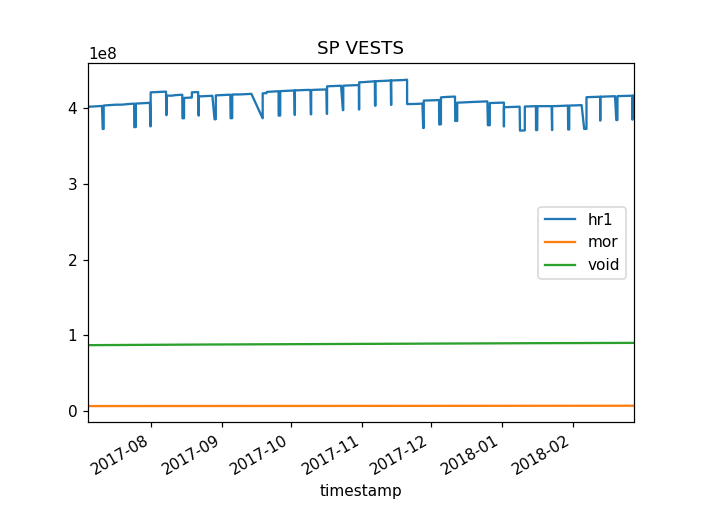

In [46]:
sp_vests[SHAREHOLDERS].plot(title='SP VESTS');

<IPython.core.display.Javascript object>


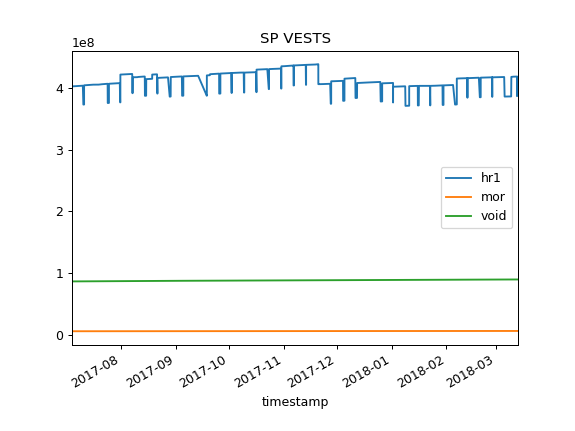

In [5]:
sp_vests[SHAREHOLDERS].plot(title='SP VESTS');

<IPython.core.display.Javascript object>


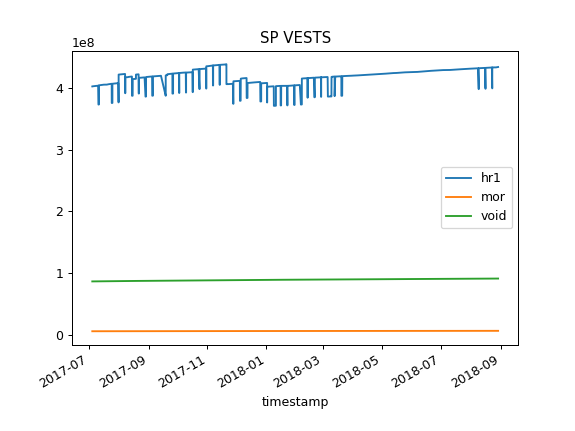

In [105]:
sp_vests[SHAREHOLDERS].plot(title='SP VESTS');

<IPython.core.display.Javascript object>


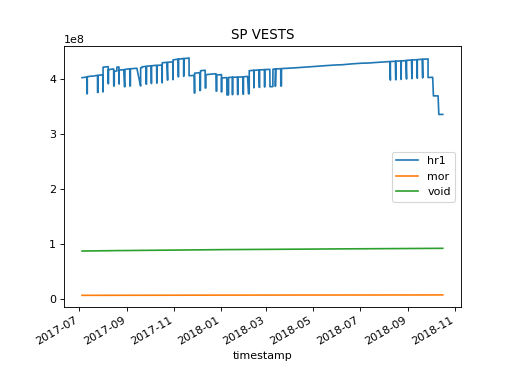

In [10]:
sp_vests[SHAREHOLDERS].plot(title='SP VESTS');

In [106]:
time_diff = all_rewards['hr1'].index.max() - all_rewards['hr1'].index.min()
time_diff

Timedelta('420 days 21:50:21')

## Profit

In [26]:
15150.364 / time_diff.total_seconds() * 3600 * 24 * 7

453.02799488044866

In [25]:
steem_vest_ratio = get_steem_vest_ratio_at(datetime.utcnow(), sp_vests.reset_index('timestamp'))
profit_steem = {name: (all_rewards[name].sum()) * steem_vest_ratio for name in SHAREHOLDERS}
print('Total profit for given period (calculated at %s)' % (datetime.utcnow()))
[print(' %s: %.3f STEEM' % (k,v)) for k,v in profit_steem.items()];
print('\n\t*using steem_vest_ratio of %f' % steem_vest_ratio)

Total profit for given period
 hr1: 9665.052 STEEM
 mor: 133.297 STEEM
 void: 922.767 STEEM


In [30]:
steem_vest_ratio = get_steem_vest_ratio_at(datetime.utcnow(), sp_vests.reset_index('timestamp'))
profit_steem = {name: (all_rewards[name].sum()) * steem_vest_ratio for name in SHAREHOLDERS}
print('Total profit for given period (calculated at %s)' % (datetime.utcnow()))
[print(' %s: %.3f STEEM' % (k,v)) for k,v in profit_steem.items()];
print('\n\t*using steem_vest_ratio of %f' % steem_vest_ratio)

Total profit for given period (calculated at 2018-02-23 15:55:53.505376)
 hr1: 15150.377 STEEM
 mor: 212.707 STEEM
 void: 1463.345 STEEM

	*using steem_vest_ratio of 0.000489


In [48]:
steem_vest_ratio = get_steem_vest_ratio_at(datetime.utcnow(), sp_vests.reset_index('timestamp'))
profit_steem = {name: (all_rewards[name].sum()) * steem_vest_ratio for name in SHAREHOLDERS}
print('Total profit for given period (calculated at %s)' % (datetime.utcnow()))
[print(' %s: %.3f STEEM' % (k,v)) for k,v in profit_steem.items()];
print('\n\t*using steem_vest_ratio of %f' % steem_vest_ratio)

Total profit for given period (calculated at 2018-02-27 11:20:58.815817)
 hr1: 15305.880 STEEM
 mor: 214.945 STEEM
 void: 1478.487 STEEM

	*using steem_vest_ratio of 0.000489


In [6]:
steem_vest_ratio = get_steem_vest_ratio_at(datetime.utcnow(), sp_vests.reset_index('timestamp'))
profit_steem = {name: (all_rewards[name].sum()) * steem_vest_ratio for name in SHAREHOLDERS}
print('Total profit for given period (calculated at %s)' % (datetime.utcnow()))
[print(' %s: %.3f STEEM' % (k,v)) for k,v in profit_steem.items()];
print('\n\t*using steem_vest_ratio of %f' % steem_vest_ratio)

Total profit for given period (calculated at 2018-03-16 09:27:48.663586)
 hr1: 15904.618 STEEM
 mor: 223.661 STEEM
 void: 1537.412 STEEM

	*using steem_vest_ratio of 0.000490


In [107]:
steem_vest_ratio = get_steem_vest_ratio_at(datetime.utcnow(), sp_vests.reset_index('timestamp'))
profit_steem = {name: (all_rewards[name].sum()) * steem_vest_ratio for name in SHAREHOLDERS}
print('Total profit for given period (calculated at %s)' % (datetime.utcnow()))
[print(' %s: %.3f STEEM' % (k,v)) for k,v in profit_steem.items()];
print('\n\t*using steem_vest_ratio of %f' % steem_vest_ratio)

Total profit for given period (calculated at 2018-08-30 09:04:04.331875)
 hr1: 23655.429 STEEM
 mor: 335.119 STEEM
 void: 2284.406 STEEM

	*using steem_vest_ratio of 0.000494


In [12]:
steem_vest_ratio = get_steem_vest_ratio_at(datetime.utcnow(), sp_vests.reset_index('timestamp'))
profit_steem = {name: (all_rewards[name].sum()) * steem_vest_ratio for name in SHAREHOLDERS}
print('Total profit for given period (calculated at %s)' % (datetime.utcnow()))
[print(' %s: %.3f STEEM' % (k,v)) for k,v in profit_steem.items()];
print('\n\t*using steem_vest_ratio of %f' % steem_vest_ratio)

Total profit for given period (calculated at 2018-10-20 12:27:37.755386)
 hr1: 25267.578 STEEM
 mor: 358.590 STEEM
 void: 2440.264 STEEM

	*using steem_vest_ratio of 0.000496


#### Received rewards for past N days

In [36]:
days= 28
all_rewards_now = all_rewards[all_rewards.index > (datetime.utcnow() - timedelta(days=days))]

steem_vest_ratio = get_steem_vest_ratio_at(datetime.utcnow(), sp_vests.reset_index('timestamp'))
profit_steem = {name: (all_rewards_now[name].sum()) * steem_vest_ratio for name in SHAREHOLDERS}
print('Total profit for last %d days (calculated at %s)' % (days, datetime.utcnow()))
[print(' %s: %.3f STEEM' % (k,v)) for k,v in profit_steem.items()];
print('\n\t*using steem_vest_ratio of %f' % steem_vest_ratio)

Total profit for last 28 days (calculated at 2018-02-23 16:14:10.970440)
 hr1: 1450.190 STEEM
 mor: 21.232 STEEM
 void: 143.866 STEEM

	*using steem_vest_ratio of 0.000489


In [49]:
days= 28
all_rewards_now = all_rewards[all_rewards.index > (datetime.utcnow() - timedelta(days=days))]

steem_vest_ratio = get_steem_vest_ratio_at(datetime.utcnow(), sp_vests.reset_index('timestamp'))
profit_steem = {name: (all_rewards_now[name].sum()) * steem_vest_ratio for name in SHAREHOLDERS}
print('Total profit for last %d days (calculated at %s)' % (days, datetime.utcnow()))
[print(' %s: %.3f STEEM' % (k,v)) for k,v in profit_steem.items()];
print('\n\t*using steem_vest_ratio of %f' % steem_vest_ratio)

Total profit for last 28 days (calculated at 2018-02-27 11:21:23.944256)
 hr1: 1393.673 STEEM
 mor: 20.339 STEEM
 void: 137.763 STEEM

	*using steem_vest_ratio of 0.000489


In [12]:
days= 28
all_rewards_now = all_rewards[all_rewards.index > (datetime.utcnow() - timedelta(days=days))]

steem_vest_ratio = get_steem_vest_ratio_at(datetime.utcnow(), sp_vests.reset_index('timestamp'))
profit_steem = {name: (all_rewards_now[name].sum()) * steem_vest_ratio for name in SHAREHOLDERS}
print('Total profit for last %d days (calculated at %s)' % (days, datetime.utcnow()))
[print(' %s: %.3f STEEM' % (k,v)) for k,v in profit_steem.items()];
print('\n\t*using steem_vest_ratio of %f' % steem_vest_ratio)

Total profit for last 28 days (calculated at 2018-03-16 09:47:18.301202)
 hr1: 1071.376 STEEM
 mor: 15.570 STEEM
 void: 105.285 STEEM

	*using steem_vest_ratio of 0.000490


In [108]:
days= 28
all_rewards_now = all_rewards[all_rewards.index > (datetime.utcnow() - timedelta(days=days))]

steem_vest_ratio = get_steem_vest_ratio_at(datetime.utcnow(), sp_vests.reset_index('timestamp'))
profit_steem = {name: (all_rewards_now[name].sum()) * steem_vest_ratio for name in SHAREHOLDERS}
print('Total profit for last %d days (calculated at %s)' % (days, datetime.utcnow()))
[print(' %s: %.3f STEEM' % (k,v)) for k,v in profit_steem.items()];
print('\n\t*using steem_vest_ratio of %f' % steem_vest_ratio)

Total profit for last 28 days (calculated at 2018-08-30 09:04:52.322252)
 hr1: 1237.839 STEEM
 mor: 17.850 STEEM
 void: 118.759 STEEM

	*using steem_vest_ratio of 0.000494


In [14]:
days= 28
all_rewards_now = all_rewards[all_rewards.index > (end_date - timedelta(days=days))]

steem_vest_ratio = get_steem_vest_ratio_at(datetime.utcnow(), sp_vests.reset_index('timestamp'))
profit_steem = {name: (all_rewards_now[name].sum()) * steem_vest_ratio for name in SHAREHOLDERS}
print('Total profit for last %d days (calculated at %s)' % (days, datetime.utcnow()))
[print(' %s: %.3f STEEM' % (k,v)) for k,v in profit_steem.items()];
print('\n\t*using steem_vest_ratio of %f' % steem_vest_ratio)

Total profit for last 28 days (calculated at 2018-10-20 12:29:33.437584)
 hr1: 550.535 STEEM
 mor: 8.142 STEEM
 void: 53.947 STEEM

	*using steem_vest_ratio of 0.000496


#### Received rewards since the beginning of this year

In [119]:
new_year = datetime(year=2018, month=1, day=1)
all_rewards_now = all_rewards[all_rewards.index > new_year]

steem_vest_ratio = get_steem_vest_ratio_at(datetime.utcnow(), sp_vests.reset_index('timestamp'))
profit_steem = {name: (all_rewards_now[name].sum()) * steem_vest_ratio for name in SHAREHOLDERS}
print('Total profit since the beginning of this year')
[print(' %s: %.3f STEEM' % (k,v)) for k,v in profit_steem.items()];
print('\n\t*using steem_vest_ratio of %f' % steem_vest_ratio)

Total profit since the beginning of this year
 hr1: 10731.257 STEEM
 mor: 155.286 STEEM
 void: 1043.843 STEEM

	*using steem_vest_ratio of 0.000494


In [16]:
new_year = datetime(year=2018, month=1, day=1)
all_rewards_now = all_rewards[all_rewards.index > new_year]

steem_vest_ratio = get_steem_vest_ratio_at(datetime.utcnow(), sp_vests.reset_index('timestamp'))
profit_steem = {name: (all_rewards_now[name].sum()) * steem_vest_ratio for name in SHAREHOLDERS}
print('Total profit since the beginning of this year')
[print(' %s: %.3f STEEM' % (k,v)) for k,v in profit_steem.items()];
print('\n\t*using steem_vest_ratio of %f' % steem_vest_ratio)

Total profit since the beginning of this year
 hr1: 12308.205 STEEM
 mor: 178.267 STEEM
 void: 1196.321 STEEM

	*using steem_vest_ratio of 0.000496


#### Profit in percent since the beginning

In [26]:
profit_percent = {name: all_rewards[name].sum() / sp_vests.iloc[0][name] for name in SHAREHOLDERS}
print('Percentual profit for given period')
[print(' %s: %.2f%%' % (k,v*100)) for k,v in profit_percent.items()];

Percentual profit for given period
 hr1: 4.94%
 mor: 4.42%
 void: 2.18%


In [10]:
profit_percent = {name: all_rewards[name].sum() / sp_vests.iloc[0][name] for name in SHAREHOLDERS}
print('Percentual profit for given period')
[print(' %s: %.2f%%' % (k,v*100)) for k,v in profit_percent.items()];

Percentual profit for given period
 hr1: 7.70%
 mor: 7.01%
 void: 3.45%


In [50]:
profit_percent = {name: all_rewards[name].sum() / sp_vests.iloc[0][name] for name in SHAREHOLDERS}
print('Percentual profit for given period')
[print(' %s: %.2f%%' % (k,v*100)) for k,v in profit_percent.items()];

Percentual profit for given period
 hr1: 7.78%
 mor: 7.08%
 void: 3.48%


In [8]:
profit_percent = {name: all_rewards[name].sum() / sp_vests.iloc[0][name] for name in SHAREHOLDERS}
print('Percentual profit for given period (calculated at %s)' % datetime.utcnow())
[print(' %s: %.2f%%' % (k,v*100)) for k,v in profit_percent.items()];

Percentual profit for given period (calculated at 2018-03-16 09:29:13.508617)
 hr1: 8.08%
 mor: 7.36%
 void: 3.62%


In [121]:
profit_percent = {name: all_rewards[name].sum() / sp_vests.iloc[0][name] for name in SHAREHOLDERS}
print('Percentual profit for given period (calculated at %s)' % datetime.utcnow())
[print(' %s: %.2f%%' % (k,v*100)) for k,v in profit_percent.items()];

Percentual profit for given period (calculated at 2018-08-30 09:10:26.289222)
 hr1: 11.91%
 mor: 10.94%
 void: 5.33%


In [17]:
profit_percent = {name: all_rewards[name].sum() / sp_vests.iloc[0][name] for name in SHAREHOLDERS}
print('Percentual profit for given period (calculated at %s)' % datetime.utcnow())
[print(' %s: %.2f%%' % (k,v*100)) for k,v in profit_percent.items()];

Percentual profit for given period (calculated at 2018-10-20 12:30:30.899659)
 hr1: 12.68%
 mor: 11.67%
 void: 5.68%


#### Annual profit

In [28]:
delta = (all_rewards.index[-1] - all_rewards.index[0]).total_seconds()
profit_percent_yr = {name: x / delta * 365.25 * 24 * 3600 for name, x in profit_percent.items()}
print('Annual percentual profit (projection)')
[print(' %s: %.2f%%' % (k,v*100)) for k,v in profit_percent_yr.items()];

Annual percentual profit (projection)
 hr1: 13.64%
 mor: 12.20%
 void: 6.03%


In [11]:
delta = (all_rewards.index[-1] - all_rewards.index[0]).total_seconds()
profit_percent_yr = {name: x / delta * 365.25 * 24 * 3600 for name, x in profit_percent.items()}
print('Annual percentual profit (projection)')
[print(' %s: %.2f%%' % (k,v*100)) for k,v in profit_percent_yr.items()];

Annual percentual profit (projection)
 hr1: 12.02%
 mor: 10.94%
 void: 5.38%


In [51]:
delta = (all_rewards.index[-1] - all_rewards.index[0]).total_seconds()
profit_percent_yr = {name: x / delta * 365.25 * 24 * 3600 for name, x in profit_percent.items()}
print('Annual percentual profit (projection)')
[print(' %s: %.2f%%' % (k,v*100)) for k,v in profit_percent_yr.items()];

Annual percentual profit (projection)
 hr1: 11.94%
 mor: 10.88%
 void: 5.35%


In [10]:
delta = (all_rewards.index[-1] - all_rewards.index[0]).total_seconds()
profit_percent_yr = {name: x / delta * 365.25 * 24 * 3600 for name, x in profit_percent.items()}
print('Annual percentual profit (projection calculated at %s)' % datetime.utcnow())
[print(' %s: %.2f%%' % (k,v*100)) for k,v in profit_percent_yr.items()];

Annual percentual profit (projection calculated at 2018-03-16 09:29:57.943332)
 hr1: 11.70%
 mor: 10.67%
 void: 5.24%


In [122]:
delta = (all_rewards.index[-1] - all_rewards.index[0]).total_seconds()
profit_percent_yr = {name: x / delta * 365.25 * 24 * 3600 for name, x in profit_percent.items()}
print('Annual percentual profit (projection calculated at %s)' % datetime.utcnow())
[print(' %s: %.2f%%' % (k,v*100)) for k,v in profit_percent_yr.items()];

Annual percentual profit (projection calculated at 2018-08-30 09:10:46.819145)
 hr1: 10.33%
 mor: 9.49%
 void: 4.62%


In [18]:
delta = (all_rewards.index[-1] - all_rewards.index[0]).total_seconds()
profit_percent_yr = {name: x / delta * 365.25 * 24 * 3600 for name, x in profit_percent.items()}
print('Annual percentual profit (projection calculated at %s)' % datetime.utcnow())
[print(' %s: %.2f%%' % (k,v*100)) for k,v in profit_percent_yr.items()];

Annual percentual profit (projection calculated at 2018-10-20 12:30:50.980911)
 hr1: 9.88%
 mor: 9.09%
 void: 4.42%


### What would it look like without the compound interest?

In [9]:
rews = {'reward_vests': '%.6f VESTS' % (sum(profit_steem.values())), 'timestamp': None}
split_rewards(pd.DataFrame([S0]), rews)

{'hr1': 9343.1712038695787,
 'mor': 130.05358050341155,
 'timestamp': None,
 'void': 910.07380562701007}

## Performance of voting strategy

<IPython.core.display.Javascript object>


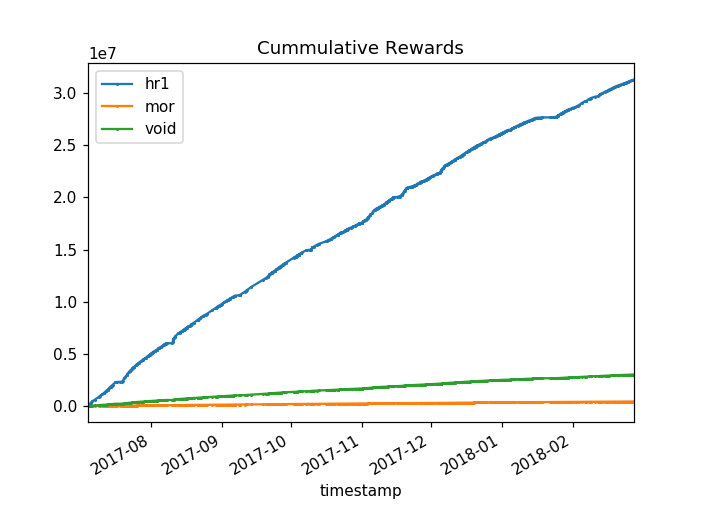

In [52]:
all_rewards[SHAREHOLDERS].cumsum().plot(title='Cummulative Rewards', marker = '.', markersize=2);

<IPython.core.display.Javascript object>


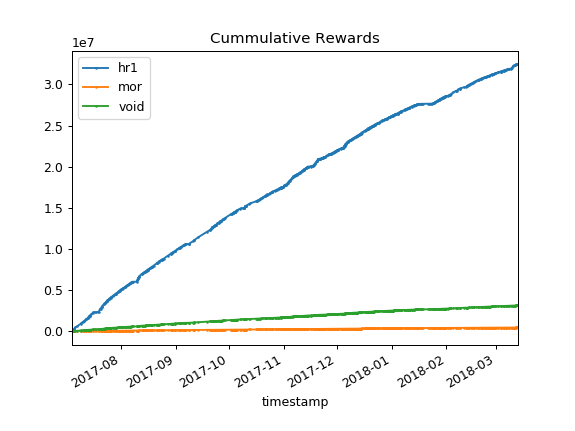

In [11]:
all_rewards[SHAREHOLDERS].cumsum().plot(title='Cummulative Rewards', marker = '.', markersize=2);

<IPython.core.display.Javascript object>


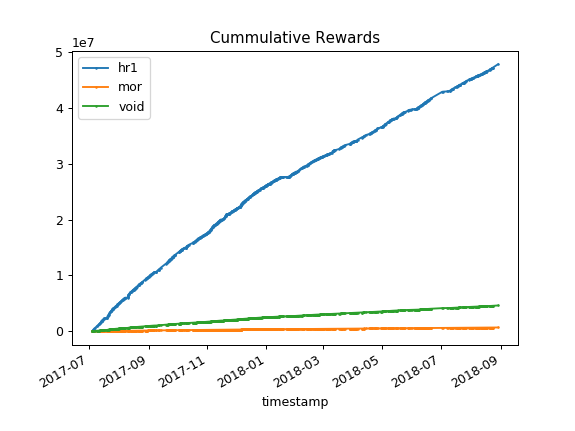

In [123]:
all_rewards[SHAREHOLDERS].cumsum().plot(title='Cummulative Rewards', marker = '.', markersize=2);

<IPython.core.display.Javascript object>


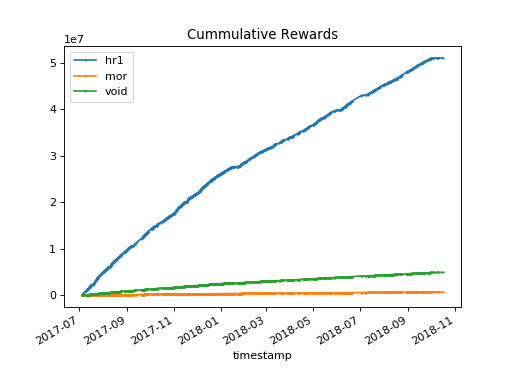

In [19]:
all_rewards[SHAREHOLDERS].cumsum().plot(title='Cummulative Rewards', marker = '.', markersize=2);

# Rolling averages adjusted for time
- because 'claim_rewards' is spaced unevenly in time

In [30]:
time_adjusted_diffs = []
last = None
for ir in all_rewards.iterrows():
    if last:
        diff = (ir[1]['hr1']) / (ir[0] - last[0]).total_seconds()
        time_adjusted_diffs.append(diff)
    
    last = ir

outlier = pd.np.array(time_adjusted_diffs).argmax()
print('removing outlier %.2f on idx %d' % (time_adjusted_diffs[outlier], outlier))
replacement = pd.np.nan

time_adjusted_diffs[outlier] = replacement
time_adjusted_diffs = [pd.np.nan] + time_adjusted_diffs

all_rewards['time_adjusted_diffs'] = time_adjusted_diffs

removing outlier 73.80 on idx 228


<IPython.core.display.Javascript object>


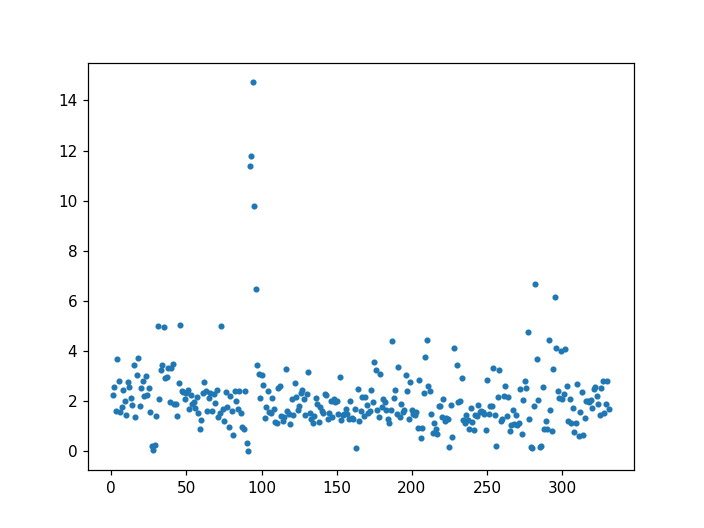

In [31]:
plt.figure()
plt.plot(time_adjusted_diffs, '.')

<IPython.core.display.Javascript object>


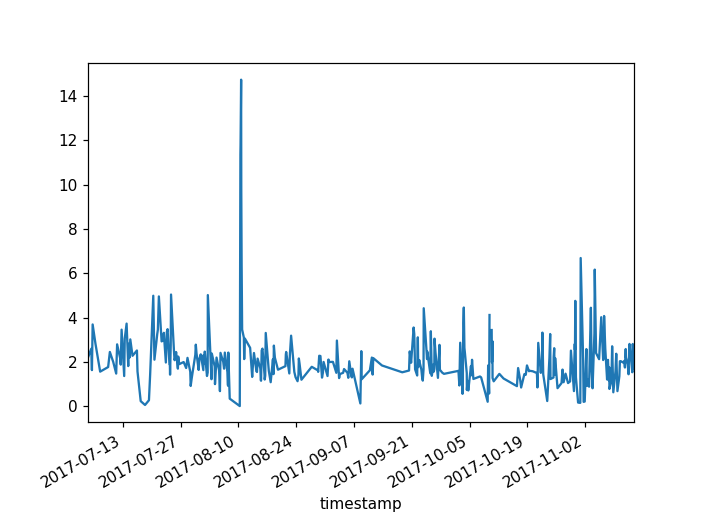

In [32]:
plt.figure()
all_rewards['time_adjusted_diffs'].plot();

<IPython.core.display.Javascript object>


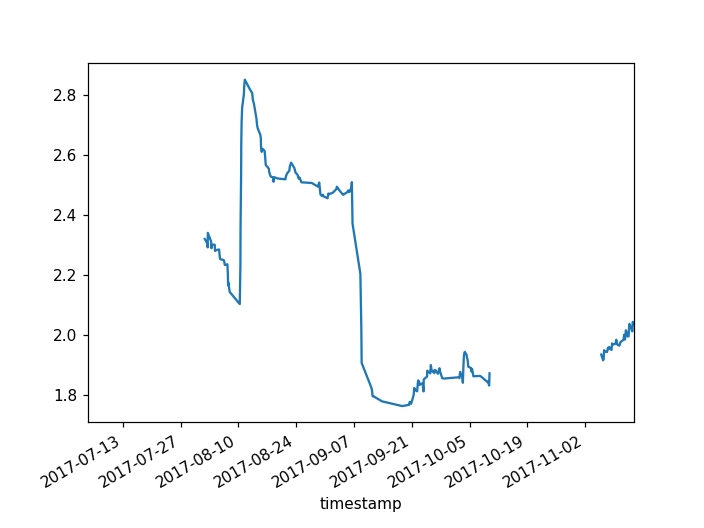

In [33]:
plt.figure()
win_day = all_rewards.shape[0] / (all_rewards.index[-1] - all_rewards.index[0]).total_seconds() * 3600 * 24
win_week = win_day * 7
win_month = win_week * 4

# window = int(win_day)
# window = int(win_week)
window = int(win_month)
all_rewards['time_adjusted_diffs'].rolling(window=window).mean().plot();

In [34]:
def plot_time_adjusted_diff_means(days):
    window = timedelta(days=days)
    time_adjusted_means = []
    for ir in all_rewards.iterrows():
        end_time = ir[0]
    #     end_time = min(start_time + window, all_rewards.index[-1])
        start_time = end_time - window

    #     time_diff = (end_time - start_time).total_seconds()

    #         t_a_mean = all_rewards[(all_rewards.index >= start_time) & (all_rewards.index < end_time)]['time_adjusted_diffs'].sum() / time_diff
        t_a_mean = all_rewards[(all_rewards.index > start_time) & (all_rewards.index <= end_time)]['time_adjusted_diffs'].mean()

        time_adjusted_means.append(t_a_mean)

    col_name = 'time_adjusted_means_%d' % days
    all_rewards[col_name] = time_adjusted_means
    plt.figure()
    all_rewards[col_name].plot(title='time adjusted diff means (%d days)' % days)

<IPython.core.display.Javascript object>


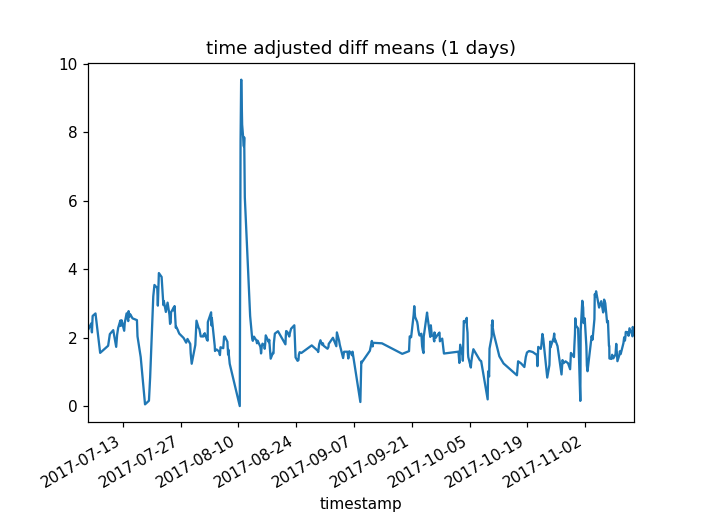

In [35]:
plot_time_adjusted_diff_means(days=1)

<IPython.core.display.Javascript object>


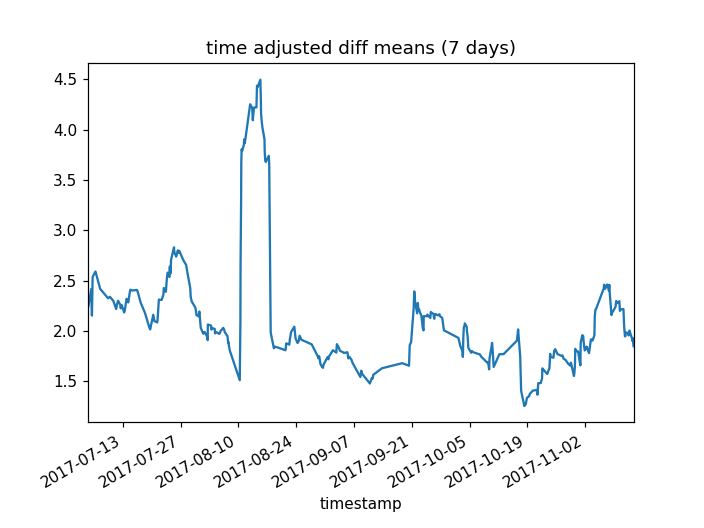

In [36]:
plot_time_adjusted_diff_means(days=7)

<IPython.core.display.Javascript object>


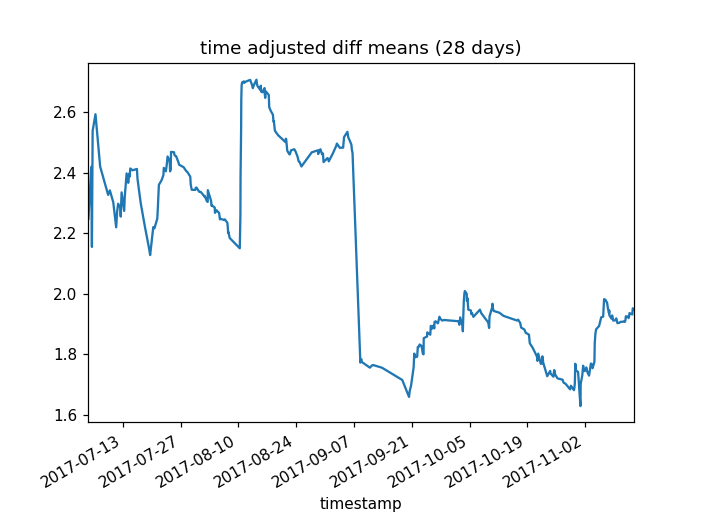

In [37]:
plot_time_adjusted_diff_means(days=28)

In [19]:
all_rewards

,hr1,mor,void,time_adjusted_diffs,time_adjusted_means_1,time_adjusted_means_7,time_adjusted_means_28
timestamp,,,,,,,
2017-07-04 12:52:45,38375.365249,534.171273,3737.961548,NaN,NaN,NaN,NaN
2017-07-04 15:15:54,19299.334716,268.638666,1879.767411,2.246983,2.246983,2.246983,2.246983
2017-07-05 07:52:54,154982.030980,2157.280490,15094.989031,2.590806,2.418895,2.418895,2.418895
2017-07-05 11:42:42,22414.505578,311.994599,2182.718531,1.625653,2.154481,2.154481,2.154481
2017-07-05 15:52:57,55376.066127,770.795108,5392.357627,3.688050,2.634836,2.537873,2.537873
2017-07-06 08:24:00,167181.190047,2327.028135,16278.500330,2.811516,2.708406,2.592602,2.592602
2017-07-07 11:34:51,152283.062168,2119.619447,14824.813164,1.556275,1.556275,2.419881,2.419881
2017-07-09 10:01:39,295064.803550,4106.922291,28719.288535,1.764657,1.764657,2.326277,2.326277
2017-07-09 19:59:18,87677.601282,1220.320102,8530.753339,2.445065,2.104861,2.341126,2.341126
